<a href="https://colab.research.google.com/github/mocccca/cmor438/blob/main/Unsupervised%20Learning/DBSCAN/DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DBSCAN Clustering Overview

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** is an unsupervised learning algorithm used to identify clusters of arbitrary shape and to detect outliers in datasets. Unlike K-Means, it does not require specifying the number of clusters in advance and works by grouping together closely packed points, marking as outliers those points that lie alone in low-density regions.



## General Process

1. **Input**  
   A set of feature vectors (data points) without labels.

2. **Core Concepts**  
   - **Epsilon (ε)**: The maximum distance between two points for them to be considered part of the same neighborhood.
   - **MinPts**: The minimum number of points required to form a dense region (i.e., a cluster).

3. **Steps**
   - Classify each point as:
     - **Core point**: Has at least `MinPts` points within its ε neighborhood.
     - **Border point**: Within ε of a core point but has fewer than `MinPts` points in its own ε neighborhood.
     - **Noise point**: Neither a core nor border point; considered an outlier.
   - Form clusters by connecting all core points that are density-reachable and including their associated border points.
   - Noise points remain unclustered.

4. **Stopping Criteria**
   - DBSCAN stops when all points have been visited and either assigned to a cluster or marked as noise.



## Advantages of DBSCAN

- **No Need to Specify Number of Clusters**  
  Unlike K-Means, DBSCAN automatically determines the number of clusters based on data density.

- **Identifies Arbitrarily Shaped Clusters**  
  Can detect clusters of any shape, not just spherical ones.

- **Handles Noise and Outliers**  
  Explicitly labels points that don’t belong to any cluster as noise.

- **Scales Well to Large Datasets**  
  Especially with indexing structures (e.g., k-d trees).



## Disadvantages of DBSCAN

- **Sensitive to ε and MinPts**  
  Choosing appropriate values for these parameters is crucial and often non-trivial.

- **Difficulty with Varying Densities**  
  Struggles when clusters have very different densities.

- **Performance Degrades in High Dimensions**  
  Distance-based metrics can become less meaningful as dimensionality increases.



## Application to This Dataset

In this project, DBSCAN was applied using participants' **Big Five personality trait scores** to explore patterns predicting their **dominant RIASEC type** based on John L. Holland’s theory of careers and vocational choice.

- **Input Variables**:  
  Big Five personality dimensions:
  - `neuroticism`
  - `extraversion`
  - `openness`
  - `agreeableness`
  - `conscientiousness`

- **Output Variable**:  
  `dominant_riasec` — the RIASEC dimension with the highest score for each participant, representing their primary vocational interest profile.



### Goal

The goal was to use **DBSCAN** to identify dense personality-based clusters and investigate how these clusters align with or predict participants’ **dominant RIASEC** types.  
This approach allowed for the detection of natural groupings and outliers without pre-specifying the number of clusters, providing insights into personality-interest connections.



In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

In [27]:
class BigFiveRIASECAnalyzer:
    def __init__(self, eps=0.5, min_samples=5):
        """
        Initialize analyzer with DBSCAN parameters

        Parameters:
        - eps: Maximum distance between samples
        - min_samples: Minimum cluster size
        """
        self.eps = eps
        self.min_samples = min_samples
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=2)

    def preprocess_data(self, df, features):
        """Prepare Big Five features for clustering"""
        self.features = features
        X = df[features].values.astype(float)
        self.X_scaled = self.scaler.fit_transform(X)
        return self.X_scaled

    def find_optimal_eps(self, k=4):
        """Estimate optimal eps using k-distance graph"""
        neighbors = NearestNeighbors(n_neighbors=k)
        neighbors_fit = neighbors.fit(self.X_scaled)
        distances, _ = neighbors_fit.kneighbors(self.X_scaled)
        distances = np.sort(distances[:, -1], axis=0)

        plt.figure(figsize=(10,6))
        plt.plot(distances)
        plt.xlabel('Points sorted by distance')
        plt.ylabel(f'{k}-NN distance')
        plt.title('K-Distance Graph for Eps Estimation')
        plt.show()

        return np.percentile(distances, 95)  # Suggest 95th percentile

    def fit_clusters(self):
        """Perform DBSCAN clustering"""
        self.dbscan = DBSCAN(eps=self.eps,
                            min_samples=self.min_samples)
        self.labels = self.dbscan.fit_predict(self.X_scaled)
        return self.labels

    def evaluate_clusters(self):
        """Evaluate clustering quality"""
        n_clusters = len(set(self.labels)) - (1 if -1 in self.labels else 0)

        metrics = {
            'n_clusters': n_clusters,
            'n_noise': list(self.labels).count(-1),
            'silhouette': (silhouette_score(self.X_scaled, self.labels)
                          if n_clusters > 1 else np.nan)
        }
        return metrics

    def visualize_clusters(self, df, true_labels_col='dominant_riasec'):
        """Visualize results with PCA"""
        X_pca = self.pca.fit_transform(self.X_scaled)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

        # True RIASEC labels
        sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                       hue=df[true_labels_col],
                       palette='viridis', ax=ax1)
        ax1.set_title('True RIASEC Distribution')

        # DBSCAN clusters
        sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                       hue=self.labels,
                       palette='tab10', ax=ax2)
        ax2.set_title('DBSCAN Clusters')

        plt.show()

    def analyze_cluster_profiles(self, df):
        """Analyze Big Five patterns in each cluster"""
        results = df.copy()
        results['cluster'] = self.labels

        # 1. Cluster composition
        print("\nRIASEC Type Distribution by Cluster:")
        print(pd.crosstab(results['cluster'],
                         results['dominant_riasec'],
                         normalize='index'))

        # 2. Big Five means
        print("\nBig Five Personality Profiles:")
        big_five_means = results.groupby('cluster')[
            ['openness_composite',
             'conscientiousness_composite',
             'extraversion_composite',
             'agreeableness_composite',
             'neuroticism_composite']
        ].mean()
        print(big_five_means)

        return big_five_means

In [29]:
# data preparation
url = "https://raw.githubusercontent.com/mocccca/cmor438/main/Leisure_Intereset_Dataset.csv"
li = pd.read_csv(url)

# Define Big Five features
big_five_cols = [
    'openness_composite',
    'extraversion_composite',
    'conscientiousness_composite',
    'agreeableness_composite',
    'neuroticism_composite'
]

# Create clean LIQ DataFrame
li1 = li[big_five_cols].copy()
for col in big_five_cols:
    li1[col] = pd.to_numeric(li1[col], errors='coerce')
li1 = li1.fillna(li1.mean())


# Create RIASEC scores (with error handling)
riasec_df = pd.DataFrame({
    'ip_realistic': li['ipa_realistic'].combine_first(li['ipb_realistic']),
    'ip_investigative': li['ipa_investigative'].combine_first(li['ipb_investigative']),
    'ip_artistic': li['ipa_artistic'].combine_first(li['ipb_artistic']),
    'ip_social': li['ipa_social'].combine_first(li['ipb_social']),
    'ip_enterprising': li['ipa_enterprising'].combine_first(li['ipb_enterprising']),
    'ip_conventional': li['ipa_conventional'].combine_first(li['ipb_conventional'])
        })
li1['dominant_riasec'] = riasec_df.idxmax(axis=1)
li1

,openness_composite,extraversion_composite,conscientiousness_composite,agreeableness_composite,neuroticism_composite,dominant_riasec
0,35,48,41,35,43,ip_social
1,41,37,33,38,40,ip_social
2,37,43,39,41,39,ip_investigative
3,35,36,43,41,37,ip_investigative
4,34,36,32,39,35,ip_artistic
...,...,...,...,...,...,...
116,42,37,35,38,34,ip_artistic
117,37,36,36,36,34,ip_realistic
118,35,39,39,42,37,ip_conventional
119,36,39,35,36,34,ip_artistic


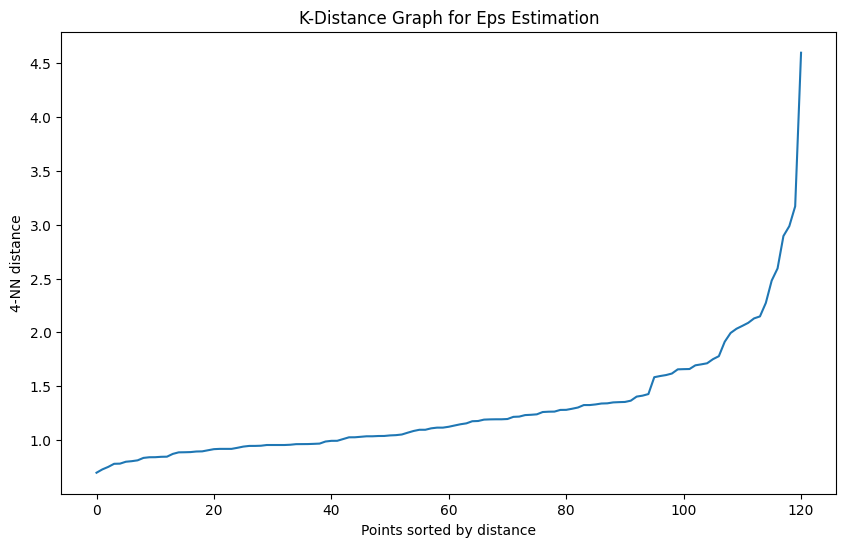

Suggested eps: 2.27


In [34]:
# Initialize analyzer
analyzer = BigFiveRIASECAnalyzer()

# Preprocess data
X_scaled = analyzer.preprocess_data(li1, big_five_cols)

# Estimate optimal eps
suggested_eps = analyzer.find_optimal_eps(k=4)
print(f"Suggested eps: {suggested_eps:.2f}")

# Set parameters (adjust based on k-distance graph)
analyzer.eps = suggested_eps
analyzer.min_samples = 5  # Start with sqrt(n_features)

In [55]:
# Perform clustering
analyzer.eps = 2.27
labels = analyzer.fit_clusters()

# Evaluate results
metrics = analyzer.evaluate_clusters()
print(f"""
Clustering Metrics:
- Number of clusters: {metrics['n_clusters']}
- Noise points: {metrics['n_noise']}
- Silhouette score: {metrics['silhouette']:.3f}
""")


Clustering Metrics:
- Number of clusters: 1
- Noise points: 3
- Silhouette score: nan



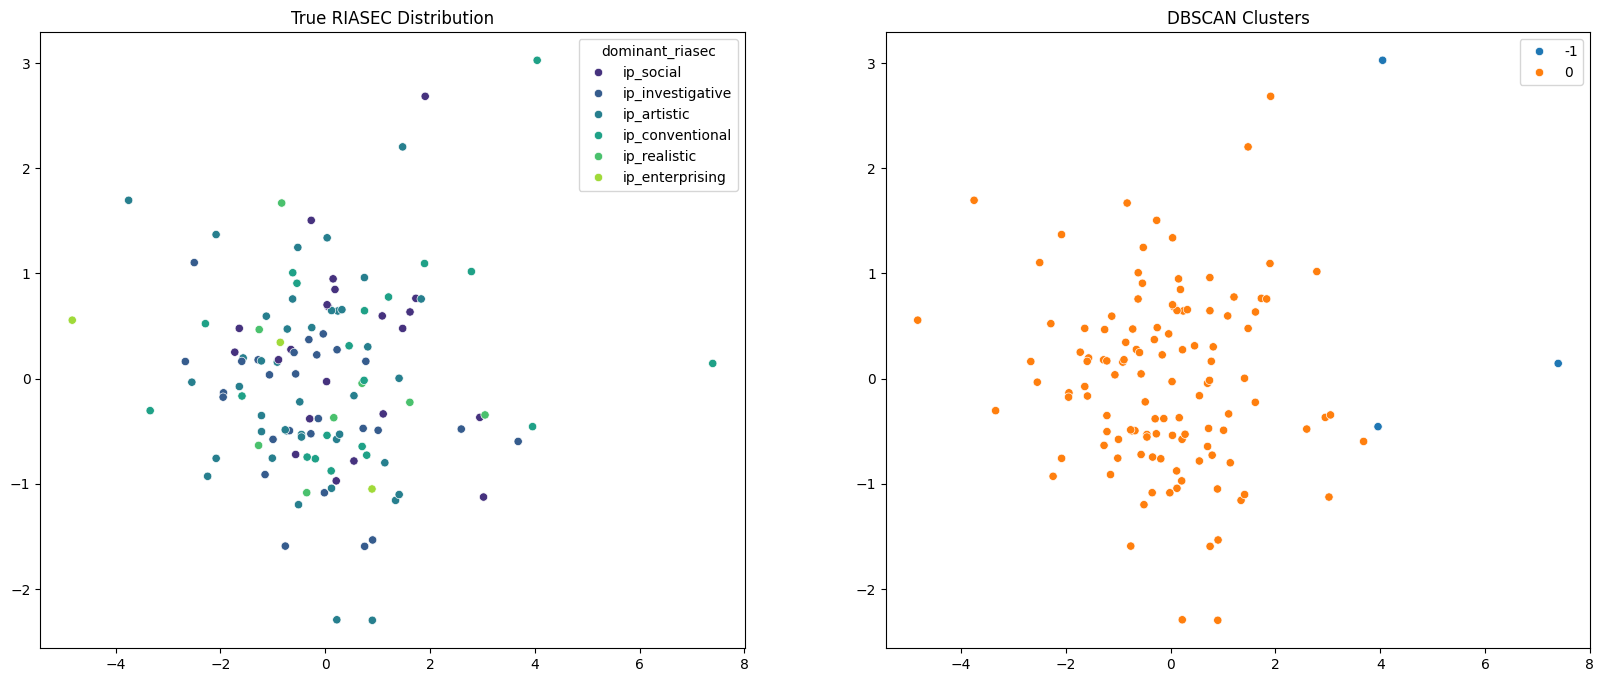


RIASEC Type Distribution by Cluster:
dominant_riasec  ip_artistic  ip_conventional  ip_enterprising  \
cluster                                                          
-1                  0.000000         1.000000         0.000000   
 0                  0.347458         0.144068         0.025424   

dominant_riasec  ip_investigative  ip_realistic  ip_social  
cluster                                                     
-1                       0.000000      0.000000   0.000000  
 0                       0.228814      0.067797   0.186441  

Big Five Personality Profiles:
         openness_composite  conscientiousness_composite  \
cluster                                                    
-1                47.666667                    45.666667   
 0                37.042373                    39.347458   

         extraversion_composite  agreeableness_composite  \
cluster                                                    
-1                    48.333333                49.666667   


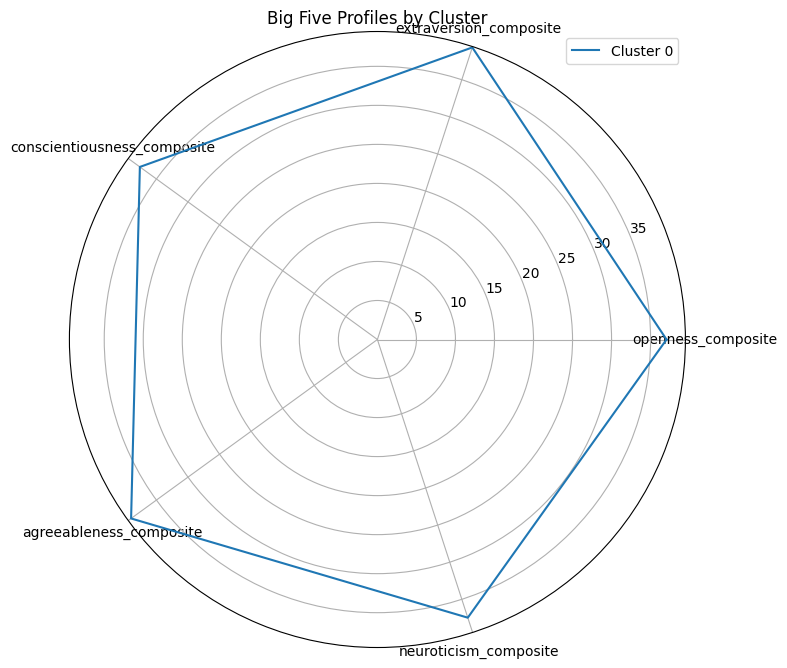

In [57]:
# Visualize clusters vs true labels
analyzer.visualize_clusters(li1)

# Analyze cluster profiles
cluster_profiles = analyzer.analyze_cluster_profiles(li1)

# Plot Big Five radar charts by cluster
plt.figure(figsize=(12,8))
for cluster in np.unique(labels):
    if cluster != -1:  # Skip noise
        cluster_data = cluster_profiles.loc[cluster]
        angles = np.linspace(0, 2*np.pi, 5, endpoint=False)
        values = cluster_data.values.tolist()
        values += values[:1]  # Close the radar chart
        angles = np.concatenate((angles, [angles[0]]))

        plt.polar(angles, values, label=f'Cluster {cluster}')

plt.xticks(angles[:-1], big_five_cols)
plt.title('Big Five Profiles by Cluster')
plt.legend()
plt.show()

DBSCAN only found one large heterogeneous main cluster, suggesting that Big Five traits alone don't cleanly separate RIASEC types.

But it's interesting to see the small outlier group (all three are conventional type with high neuroticism and high agreeableness scores). They might represent: stress-prone rule-followers or potential type-C under stress.

Let's try to adjust the eps value to see if we can get different results.

In [43]:
# Try these settings sequentially:
param_grid = [
    {'eps': 1.0, 'min_samples': 5}, # Removed 'metric'
    {'eps': 0.8, 'min_samples': 10}, # Removed 'metric'
    {'eps': 1.5, 'min_samples': 3}  # Removed 'metric'
]

for params in param_grid:
    analyzer = BigFiveRIASECAnalyzer(**params)
    X_scaled = analyzer.preprocess_data(li1, big_five_cols) # Changed df to li1
    labels = analyzer.fit_clusters()
    print(f"\nParams: {params}")
    print(pd.Series(labels).value_counts())


Params: {'eps': 1.0, 'min_samples': 5}
-1    66
 0    36
 1    15
 2     4
Name: count, dtype: int64

Params: {'eps': 0.8, 'min_samples': 10}
-1    121
Name: count, dtype: int64

Params: {'eps': 1.5, 'min_samples': 3}
 0    103
-1     14
 1      4
Name: count, dtype: int64


we can adopt eps = 1.5 to see if we can get more clusters.

In [58]:
# Perform clustering
analyzer.eps = 1.5
labels = analyzer.fit_clusters()

# Evaluate results
metrics = analyzer.evaluate_clusters()
print(f"""
Clustering Metrics:
- Number of clusters: {metrics['n_clusters']}
- Noise points: {metrics['n_noise']}
- Silhouette score: {metrics['silhouette']:.3f}
""")


Clustering Metrics:
- Number of clusters: 2
- Noise points: 14
- Silhouette score: 0.247



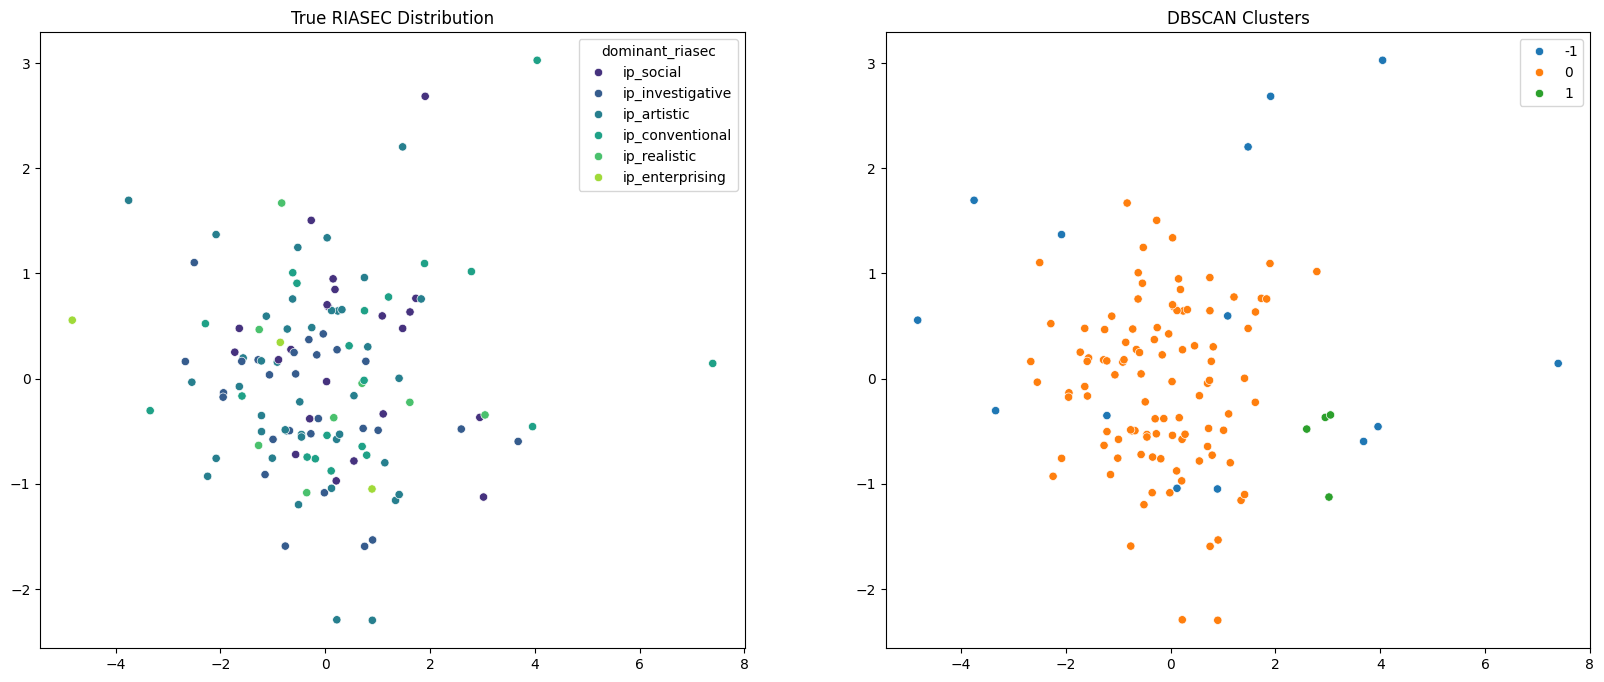


RIASEC Type Distribution by Cluster:
dominant_riasec  ip_artistic  ip_conventional  ip_enterprising  \
cluster                                                          
-1                  0.357143         0.285714         0.142857   
 0                  0.349515         0.155340         0.009709   
 1                  0.000000         0.000000         0.000000   

dominant_riasec  ip_investigative  ip_realistic  ip_social  
cluster                                                     
-1                       0.071429      0.000000   0.142857  
 0                       0.242718      0.067961   0.174757  
 1                       0.250000      0.250000   0.500000  

Big Five Personality Profiles:
         openness_composite  conscientiousness_composite  \
cluster                                                    
-1                39.571429                    40.285714   
 0                36.844660                    39.097087   
 1                41.250000                    47.2500

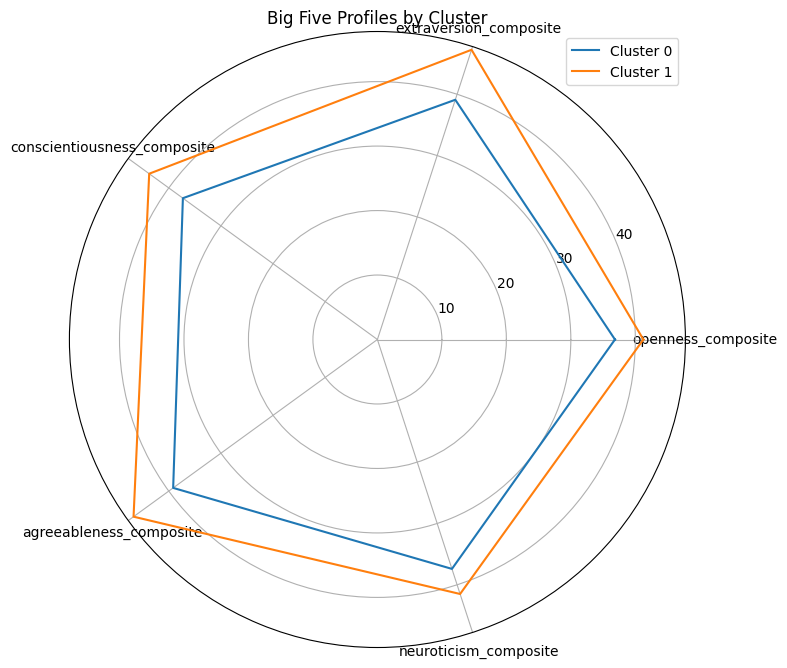

In [59]:
# Visualize clusters vs true labels
analyzer.visualize_clusters(li1)

# Analyze cluster profiles
cluster_profiles = analyzer.analyze_cluster_profiles(li1)

# Plot Big Five radar charts by cluster
plt.figure(figsize=(12,8))
for cluster in np.unique(labels):
    if cluster != -1:  # Skip noise
        cluster_data = cluster_profiles.loc[cluster]
        angles = np.linspace(0, 2*np.pi, 5, endpoint=False)
        values = cluster_data.values.tolist()
        values += values[:1]  # Close the radar chart
        angles = np.concatenate((angles, [angles[0]]))

        plt.polar(angles, values, label=f'Cluster {cluster}')

plt.xticks(angles[:-1], big_five_cols)
plt.title('Big Five Profiles by Cluster')
plt.legend()
plt.show()

a smaller group with exclusively Social (50%) + Investigative/Realistic appeared. They have distinctive high Conscientiousness (47.25) and Agreeableness (46.75), suggesting a distinct personality-activity profile.

In conclusion, for DBSCAN to be effective, it requires the data to be densely distributed, thus might not be the best choice for exploring the correlations with these variables.